In [1]:
from dataset import GTZAN
from evalutation import evaluate
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils import data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
RANDOM_STATE = 2022
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [2]:
# load data
train_db = GTZAN('./data/train.pkl')
val_db =  GTZAN('./data/val.pkl')
class_translator = {
    0 : 'blues',
    1 : 'classical',
    2 : 'country',
    3 : 'disco',
    4 : 'hiphop',
    5 : 'pop',
    6 : 'jazz',
    7 : 'metal',
    8 : 'reggae',
    9 : 'rock',
}

In [3]:
# define model
class shallowCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Sequential(
            nn.Conv2d(1, 16, (10, 23), 1, padding='same', device=device),
            nn.LeakyReLU(0.3),
            nn.MaxPool2d((1, 20))
        )
        self.layer_2 = nn.Sequential(
            nn.Conv2d(1, 16, (21, 20), padding='same', device=device),
            nn.LeakyReLU(0.3),
            nn.MaxPool2d((20, 1))
        )
        self.linear = nn.Sequential(
            nn.Linear(10240, 200, device=device),
            nn.LeakyReLU(0.3),
            nn.Dropout(0.1),
            nn.Linear(200, 10, device=device),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        out_1 = self.layer_1(x).view(x.shape[0], -1)
        out_2 = self.layer_2(x).view(x.shape[0], -1)
        out = torch.concat([out_1, out_2], dim=1)
        return self.linear(out)


# batch size = 128

In [4]:

# prepare dataset
BATCH_SIZE = 128
train_iter = data.DataLoader(train_db, batch_size=BATCH_SIZE, shuffle=True)
val_iter = data.DataLoader(val_db, batch_size=BATCH_SIZE, shuffle=False)


In [5]:
for _, X, y, _ in train_iter:
    print(X.shape, X.dtype)
    print(y.shape, y.dtype)
    break

torch.Size([128, 1, 80, 80]) torch.float32
torch.Size([128]) torch.int64


In [6]:
def train_epoch(n_epoch, model, train_iter, val_iter, loss_fn, optimizer, weight_decay=0.0001):
    model.train()
    train_loss, n_samples, batch_count = 0., 0, 0
    for _, X, y, _ in train_iter:
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_hat = model(X)
        loss = loss_fn(y_hat, y)
        # apply l1 regularization
        weights = torch.cat([p.view(-1) for n, p in model.named_parameters() if ".weight" in n])
        loss += weight_decay * torch.norm(weights, p=1)
        loss.backward()
        optimizer.step()
        train_loss += loss.detach().cpu().item()
        n_samples += X.shape[0]
        batch_count += 1
    model.eval()
    train_acc = eval_epoch(model, train_iter)
    val_acc = eval_epoch(model, val_iter)
    if n_epoch % 20 == 0:
        print('epoch: {}, train_loss: {:.4f}, train_acc: {:.4f}, val_acc: {:.4f}'.format(n_epoch, train_loss/batch_count, train_acc, val_acc))
    return train_loss/batch_count, train_acc, val_acc

def eval_epoch(model, data_iter, return_acc=True):
    model.eval()
    acc_sum, n = 0., 0
    with torch.no_grad():
        y_hat_all = None
        for _, X, y, _ in data_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = model(X)
            acc_sum += (y_hat.argmax(dim=1) == y).float().sum().cpu().item()
            n += X.shape[0]
            if y_hat_all is None:
                y_hat_all = y_hat
            else:
                y_hat_all = torch.concat([y_hat_all, y_hat], dim=0)
    if return_acc:
        return acc_sum / n
    return y_hat_all.detach().cpu()


In [38]:
# plot loss and accuracy
def plot_loss_and_acc(ax, train_loss_list, train_acc_list, val_acc_list, label_suffix:str):
    x = np.arange(1, len(train_loss_list) + 1)
    ax[0].plot(x, train_loss_list, label='%s_train'%label_suffix)
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(loc='best')
    ax[1].plot(x, train_acc_list, label='%s_train'%label_suffix)
    ax[1].plot(x, val_acc_list, label='%s_validate'%label_suffix)
    ax[1].set_ylabel('ACCURACY')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(loc='best')

# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_confusion_matrix(preds, label, label_name, title):
    fig, ax= plt.subplots(figsize = (10, 8))
    cm = confusion_matrix(preds, label)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ax = sns.heatmap(cm, annot=True, fmt='.2f', linewidths=0.5, ax=ax)
    ax.set_title(title)
    num_local = np.array(range(len(label_name)))
    ax.set_xticks(num_local, label_name)
    ax.set_yticks(num_local, label_name)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    plt.savefig('%s.pdf'%title, format='pdf')
    plt.show()



In [7]:

# hyper params
beta_1 = 0.9
beta_2 = 0.999
epsilon = 1e-8
lr = 0.00005


In [8]:

num_epochs = 200
score_list_100, score_list_200= [], []


model = shallowCNN()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(beta_1, beta_2), eps=epsilon)
loss_f = nn.CrossEntropyLoss()
train_loss_list, train_acc_list, val_acc_list = [], [], []
for epoch in range(1, num_epochs+1):
    train_loss, train_acc, val_acc = train_epoch(epoch, model, train_iter, val_iter, loss_f, optimizer)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    if epoch == 100 or epoch == 200:
        y_hat = eval_epoch(model, val_iter, return_acc=False)
        raw_score = evaluate(y_hat, './data/val.pkl')
        if epoch == 100:
            score_list_100.append(raw_score)
        else:
            score_list_200.append(raw_score)


G:\Apps\Anaconda\lib\site-packages\torch\nn\modules\conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Convolution.cpp:896.)
  return F.conv2d(input, weight, bias, self.stride,


epoch: 20, train_loss: 2.1878, train_acc: 0.4397, val_acc: 0.4104
epoch: 40, train_loss: 2.1029, train_acc: 0.5023, val_acc: 0.4403
epoch: 60, train_loss: 2.0543, train_acc: 0.5772, val_acc: 0.5128
epoch: 80, train_loss: 2.0201, train_acc: 0.5923, val_acc: 0.5037
epoch: 100, train_loss: 1.9683, train_acc: 0.6727, val_acc: 0.5680
ACCUARCY SCORES:
-------------------------------------------------------------

RAW: 56.80

-------------------------------------------------------------
epoch: 120, train_loss: 1.9427, train_acc: 0.7021, val_acc: 0.5728
epoch: 140, train_loss: 1.9195, train_acc: 0.7137, val_acc: 0.5888
epoch: 160, train_loss: 1.9063, train_acc: 0.7286, val_acc: 0.5997
epoch: 180, train_loss: 1.8832, train_acc: 0.7402, val_acc: 0.6117
epoch: 200, train_loss: 1.8748, train_acc: 0.7560, val_acc: 0.6123
ACCUARCY SCORES:
-------------------------------------------------------------

RAW: 61.23

-------------------------------------------------------------


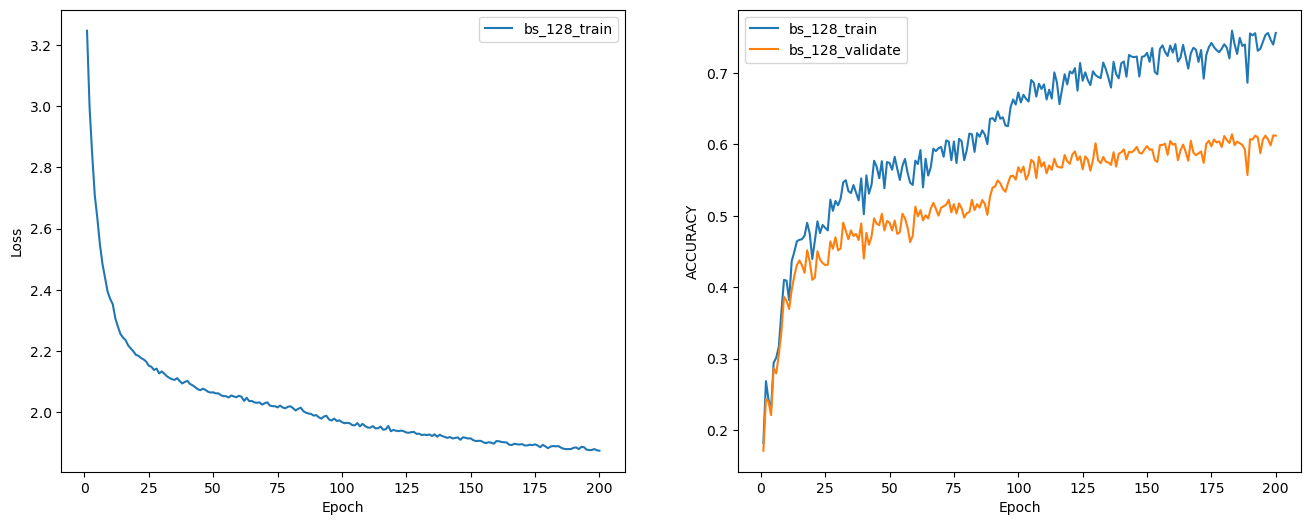

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_loss_and_acc(ax, train_loss_list, train_acc_list, val_acc_list, "bs_128")
plt.savefig('loss_acc_128.pdf', format='pdf')

In [13]:
print("The validation accuracy when trained for 100 epoch with batch size 128 is %.2f"%score_list_100[0])
print("The validation accuracy when trained for 200 epoch with batch size 128 is %.2f"%score_list_200[0])

The validation accuracy when trained for 100 epoch with batch size 128 is 56.80
The validation accuracy when trained for 200 epoch with batch size 128 is 61.23


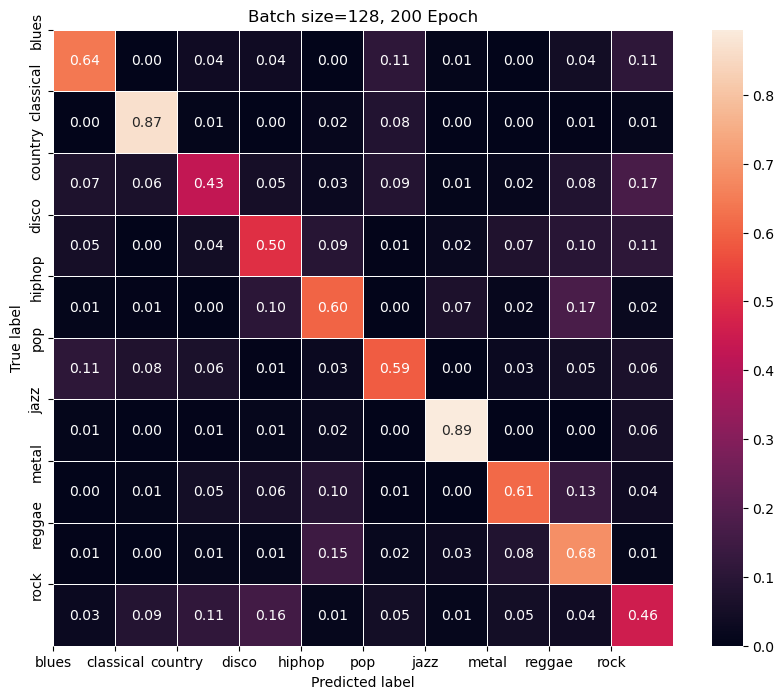

In [24]:
label_text = [class_translator[i] for i in range(10)]
import pickle
gts = pickle.load(open('./data/val.pkl', 'rb'))
labels = []
for i in range(len(gts)):
    filename, _, gt, _ = gts[i]
    labels.append(gt)

plot_confusion_matrix(np.argmax(y_hat.numpy(), axis=1), labels, label_text, 'Batch size=128, 200 Epoch')

# batch size = 256

In [25]:
# prepare dataset
BATCH_SIZE = 256
train_iter = data.DataLoader(train_db, batch_size=BATCH_SIZE, shuffle=True)
val_iter = data.DataLoader(val_db, batch_size=BATCH_SIZE, shuffle=False)


In [26]:
num_epochs = 200
score_list_100, score_list_200= [], []


model = shallowCNN()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(beta_1, beta_2), eps=epsilon)
loss_f = nn.CrossEntropyLoss()
train_loss_list, train_acc_list, val_acc_list = [], [], []
for epoch in range(1, num_epochs+1):
    train_loss, train_acc, val_acc = train_epoch(epoch, model, train_iter, val_iter, loss_f, optimizer)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    if epoch == 100 or epoch == 200:
        y_hat = eval_epoch(model, val_iter, return_acc=False)
        raw_score = evaluate(y_hat, './data/val.pkl')
        if epoch == 100:
            score_list_100.append(raw_score)
        else:
            score_list_200.append(raw_score)


epoch: 20, train_loss: 2.3953, train_acc: 0.4241, val_acc: 0.4035
epoch: 40, train_loss: 2.2242, train_acc: 0.4685, val_acc: 0.4232
epoch: 60, train_loss: 2.1254, train_acc: 0.5407, val_acc: 0.4717
epoch: 80, train_loss: 2.0743, train_acc: 0.5667, val_acc: 0.4880
epoch: 100, train_loss: 2.0541, train_acc: 0.5878, val_acc: 0.5037
ACCUARCY SCORES:
-------------------------------------------------------------

RAW: 50.37

-------------------------------------------------------------
epoch: 120, train_loss: 2.0255, train_acc: 0.6016, val_acc: 0.5203
epoch: 140, train_loss: 2.0064, train_acc: 0.6209, val_acc: 0.5221
epoch: 160, train_loss: 1.9914, train_acc: 0.6222, val_acc: 0.5208
epoch: 180, train_loss: 1.9755, train_acc: 0.6360, val_acc: 0.5363
epoch: 200, train_loss: 1.9544, train_acc: 0.6775, val_acc: 0.5763
ACCUARCY SCORES:
-------------------------------------------------------------

RAW: 57.63

-------------------------------------------------------------


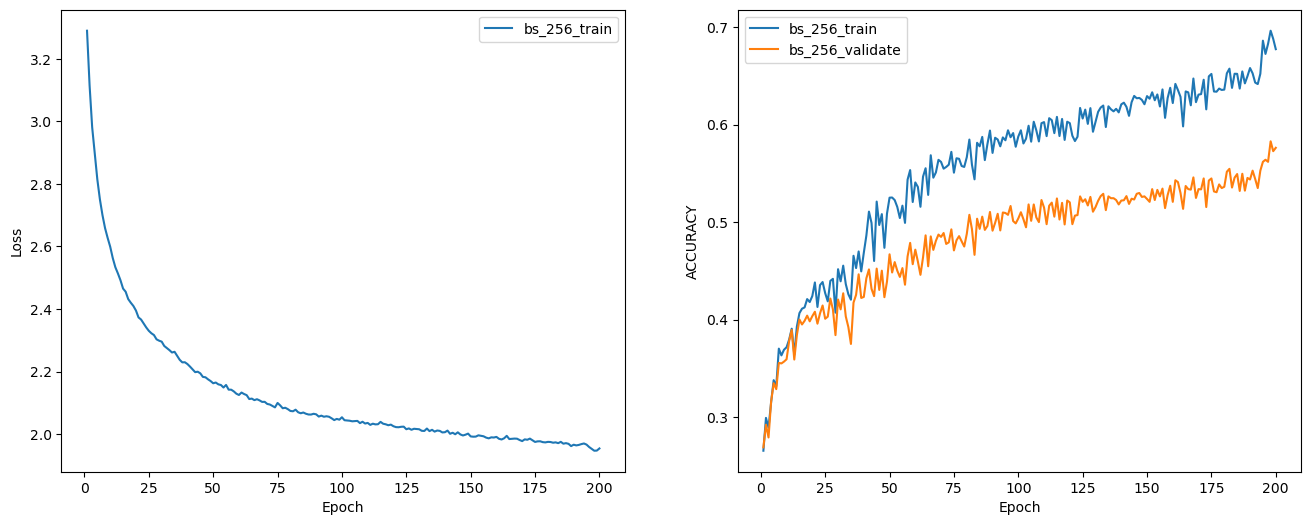

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_loss_and_acc(ax, train_loss_list, train_acc_list, val_acc_list, "bs_256")
plt.savefig('loss_acc_256.pdf', format='pdf')

In [28]:
print("The validation accuracy when trained for 100 epoch with batch size 256 is %.2f"%score_list_100[0])
print("The validation accuracy when trained for 200 epoch with batch size 256 is %.2f"%score_list_200[0])

The validation accuracy when trained for 100 epoch with batch size 256 is 50.37
The validation accuracy when trained for 200 epoch with batch size 256 is 57.63


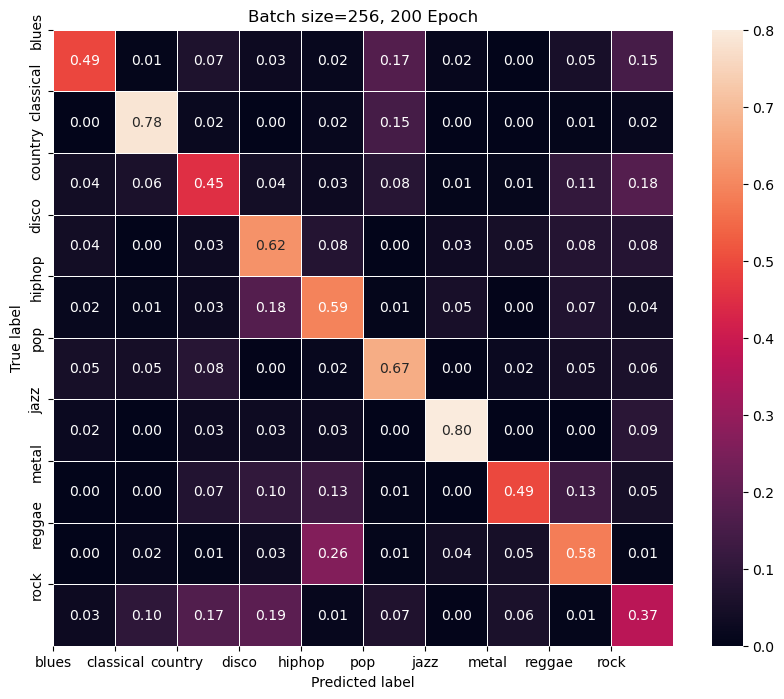

In [29]:
plot_confusion_matrix(np.argmax(y_hat.numpy(), axis=1), labels, label_text, 'Batch size=256, 200 Epoch')

# batch size = 64

In [30]:
# prepare dataset
BATCH_SIZE = 64
train_iter = data.DataLoader(train_db, batch_size=BATCH_SIZE, shuffle=True)
val_iter = data.DataLoader(val_db, batch_size=BATCH_SIZE, shuffle=False)

num_epochs = 200
score_list_100, score_list_200 = [], []

model = shallowCNN()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(beta_1, beta_2), eps=epsilon)
loss_f = nn.CrossEntropyLoss()
train_loss_list, train_acc_list, val_acc_list = [], [], []
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc, val_acc = train_epoch(epoch, model, train_iter, val_iter, loss_f, optimizer)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    if epoch == 100 or epoch == 200:
        y_hat = eval_epoch(model, val_iter, return_acc=False)
        raw_score = evaluate(y_hat, './data/val.pkl')
        if epoch == 100:
            score_list_100.append(raw_score)
        else:
            score_list_200.append(raw_score)

epoch: 20, train_loss: 2.1175, train_acc: 0.4337, val_acc: 0.4171
epoch: 40, train_loss: 2.0586, train_acc: 0.5074, val_acc: 0.4520
epoch: 60, train_loss: 2.0020, train_acc: 0.5818, val_acc: 0.4779
epoch: 80, train_loss: 1.9715, train_acc: 0.6175, val_acc: 0.5179
epoch: 100, train_loss: 1.9341, train_acc: 0.6544, val_acc: 0.5403
ACCUARCY SCORES:
-------------------------------------------------------------

RAW: 54.03

-------------------------------------------------------------
epoch: 120, train_loss: 1.9015, train_acc: 0.6978, val_acc: 0.5720
epoch: 140, train_loss: 1.8758, train_acc: 0.7060, val_acc: 0.5856
epoch: 160, train_loss: 1.8648, train_acc: 0.7376, val_acc: 0.6016
epoch: 180, train_loss: 1.8469, train_acc: 0.7424, val_acc: 0.6115
epoch: 200, train_loss: 1.8346, train_acc: 0.7380, val_acc: 0.6000
ACCUARCY SCORES:
-------------------------------------------------------------

RAW: 60.00

-------------------------------------------------------------


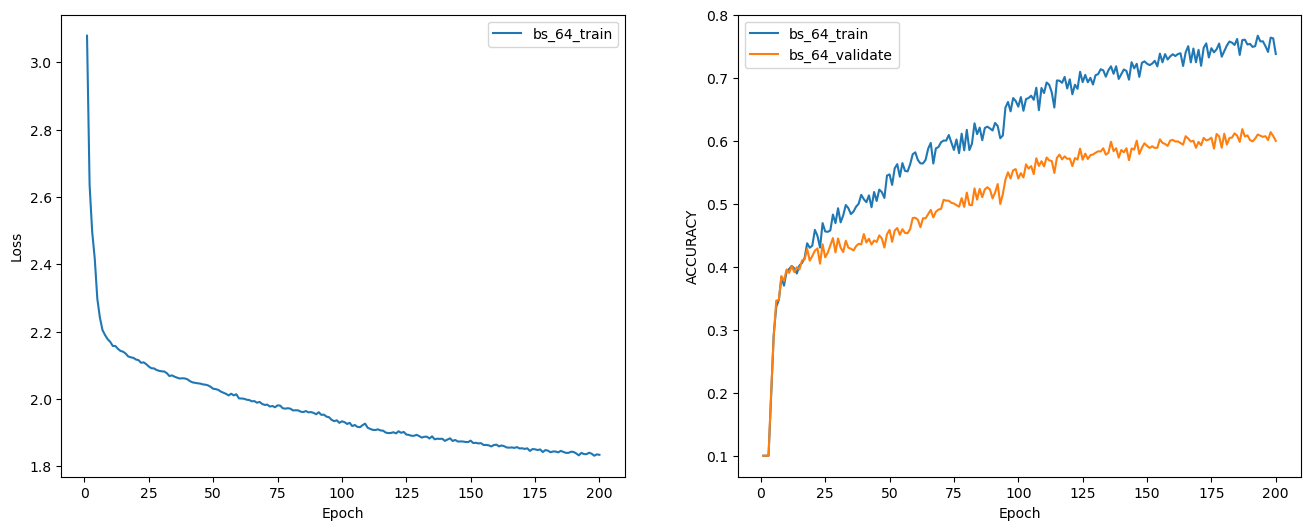

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_loss_and_acc(ax, train_loss_list, train_acc_list, val_acc_list, "bs_64")
plt.savefig('loss_acc_64.pdf', format='pdf')

In [32]:
print("The validation accuracy when trained for 100 epoch with batch size 64 is %.2f"%score_list_100[0])
print("The validation accuracy when trained for 200 epoch with batch size 64 is %.2f"%score_list_200[0])

The validation accuracy when trained for 100 epoch with batch size 64 is 54.03
The validation accuracy when trained for 200 epoch with batch size 64 is 60.00


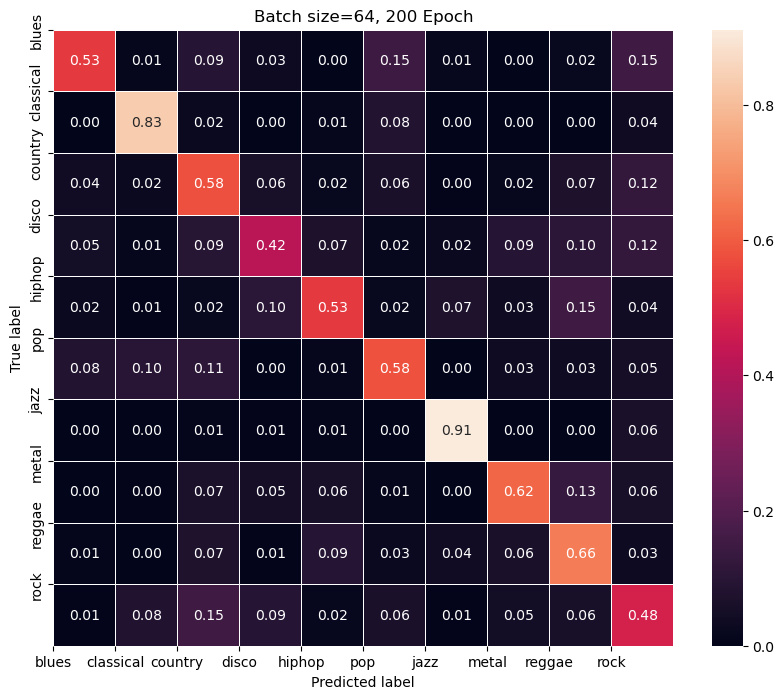

In [45]:
plot_confusion_matrix(np.argmax(y_hat.numpy(), axis=1), labels, label_text, 'Batch size=64, 200 Epoch')

The spectrogram of jazz predicted as jazz


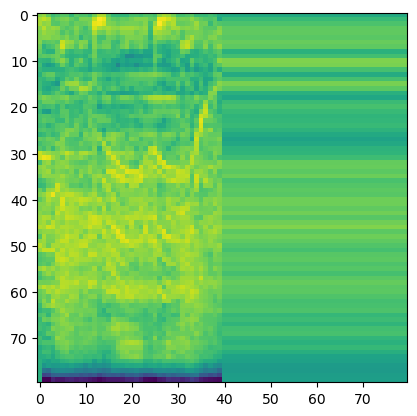

In [46]:
# print the good example
count = 0
labels = []
spectrogram = []
for i in range(len(gts)):
    filename, s, gt, _ = gts[i]
    labels.append(gt)
    spectrogram.append(s)

preds = np.argmax(y_hat.numpy(), axis=1)
for idx in range(len(labels)):
    if preds[idx] == 6 and labels[idx] == 6:
        plt.imshow(spectrogram[idx].view(80, 80))
        plt.savefig('good.pdf', format='pdf')
        break
print("The spectrogram of %s predicted as %s"%(class_translator[6], class_translator[6]))

The spectrogram of hiphop predicted as reggae


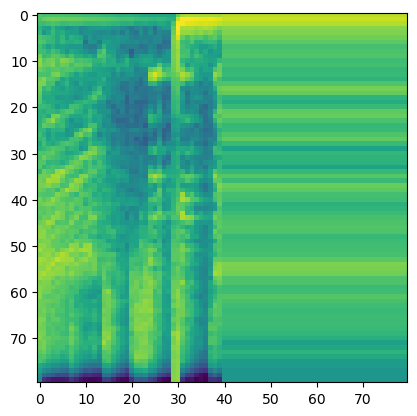

In [47]:

for idx in range(len(labels)):
    if preds[idx] == 8 and labels[idx] == 4:
        plt.imshow(spectrogram[idx].view(80, 80))
        plt.savefig('bad1.pdf', format='pdf')
        break
print("The spectrogram of %s predicted as %s"%(class_translator[4], class_translator[8]))

The spectrogram of blues predicted as pop


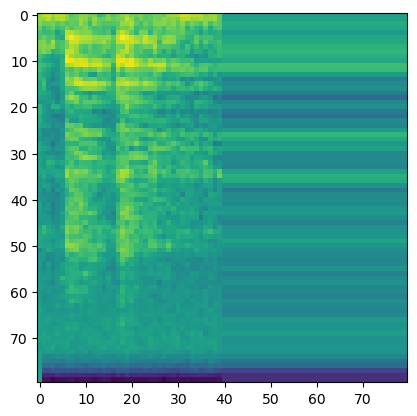

In [48]:

for idx in range(len(labels)):
    if preds[idx] == 5 and labels[idx] == 0:
        plt.imshow(spectrogram[idx].view(80, 80))
        plt.savefig('bad2.pdf', format='pdf')
        break
print("The spectrogram of %s predicted as %s"%(class_translator[0], class_translator[5]))